# Visualiser for area28 metric data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

In [2]:
# df = pd.read_json("data.json")
df = pd.read_csv("dummy.csv")
df = df.set_index('id')
df

,type,userId,sessionId,sceneId,timestamp,data
id,,,,,,
1,CORE_SCENE_JOIN,0,0,8,2021-09-03 10:26:23,"{'rating': None, 'rating_cat': None}"
2,CORE_SCENE_LEAVE,0,0,8,2021-09-03 10:45:40,"{'rating': None, 'rating_cat': None}"
3,CORE_SCENE_RATE,0,0,8,2021-09-03 10:46:55,"{'rating': 1, 'rating_cat': 'Collab Tools'}"
4,CORE_SCENE_JOIN,1,0,8,2021-09-03 10:42:24,"{'rating': None, 'rating_cat': None}"
5,CORE_SCENE_LEAVE,1,0,8,2021-09-03 13:24:02,"{'rating': None, 'rating_cat': None}"
...,...,...,...,...,...,...
1253,CORE_SCENE_LEAVE,7,70,6,2021-11-12 13:19:07,"{'rating': None, 'rating_cat': None}"
1254,CORE_SCENE_JOIN,8,70,6,2021-11-12 11:33:50,"{'rating': None, 'rating_cat': None}"
1255,CORE_SCENE_LEAVE,8,70,6,2021-11-12 16:24:21,"{'rating': None, 'rating_cat': None}"


In [3]:
import calendar

df_no_rating = df.drop(df[df['type'] == "CORE_SCENE_RATE"].index)

df_no_rating['datetime'] = [dt.datetime.strptime(str(d), '%Y-%m-%d %H:%M:%S') for d in df_no_rating['timestamp']]
durations = df_no_rating.groupby(['userId', 'sessionId'])['datetime'].diff()
df_no_rating['date'] = [dt.datetime.date(d) for d in df_no_rating['datetime']] 
df_no_rating['time'] = [dt.datetime.time(d) for d in df_no_rating['datetime']]
df_no_rating['weekday'] = [calendar.day_name[d.weekday()] for d in df_no_rating['datetime']]
df_no_rating['week_number'] = [d.isocalendar()[1] for d in df_no_rating['datetime']]

df_no_rating['duration'] = durations
df_processed = df_no_rating[['userId', 'sessionId', 'date', 'duration', 'time', 'weekday', 'week_number', 'sceneId']].copy()
df_processed = df_processed.dropna()
df_processed

,userId,sessionId,date,duration,time,weekday,week_number,sceneId
id,,,,,,,,
2,0,0,2021-09-03,0 days 00:19:17,10:45:40,Friday,35,8
5,1,0,2021-09-03,0 days 02:41:38,13:24:02,Friday,35,8
7,2,0,2021-09-03,0 days 03:56:15,14:19:30,Friday,35,8
9,3,0,2021-09-03,0 days 01:27:01,11:48:50,Friday,35,8
12,4,0,2021-09-03,0 days 02:46:51,15:10:12,Friday,35,8
...,...,...,...,...,...,...,...,...
1249,5,70,2021-11-12,0 days 02:30:35,14:21:11,Friday,45,6
1251,6,70,2021-11-12,0 days 04:18:26,14:46:06,Friday,45,6
1253,7,70,2021-11-12,0 days 03:43:34,13:19:07,Friday,45,6


In [4]:
df_no_rating.head()

,type,userId,sessionId,sceneId,timestamp,data,datetime,date,time,weekday,week_number,duration
id,,,,,,,,,,,,
1,CORE_SCENE_JOIN,0,0,8,2021-09-03 10:26:23,"{'rating': None, 'rating_cat': None}",2021-09-03 10:26:23,2021-09-03,10:26:23,Friday,35,NaT
2,CORE_SCENE_LEAVE,0,0,8,2021-09-03 10:45:40,"{'rating': None, 'rating_cat': None}",2021-09-03 10:45:40,2021-09-03,10:45:40,Friday,35,0 days 00:19:17
4,CORE_SCENE_JOIN,1,0,8,2021-09-03 10:42:24,"{'rating': None, 'rating_cat': None}",2021-09-03 10:42:24,2021-09-03,10:42:24,Friday,35,NaT
5,CORE_SCENE_LEAVE,1,0,8,2021-09-03 13:24:02,"{'rating': None, 'rating_cat': None}",2021-09-03 13:24:02,2021-09-03,13:24:02,Friday,35,0 days 02:41:38
6,CORE_SCENE_JOIN,2,0,8,2021-09-03 10:23:15,"{'rating': None, 'rating_cat': None}",2021-09-03 10:23:15,2021-09-03,10:23:15,Friday,35,NaT


In [5]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install ipywidgets -q

In [6]:
import ipywidgets as widgets
menu_timeframe = widgets.Dropdown(
       options=['Day', 'Week', 'Month', 'Year', 'All Time'],
       description='Timeframe:')
menu_timeframe

Dropdown(description='Timeframe:', options=('Day', 'Week', 'Month', 'Year', 'All Time'), value='Day')

In [14]:
menu_timeframe.value

'Month'

In [15]:
today = dt.datetime.now()
timeframe_ago = dt.datetime(1970, 1, 1)
if menu_timeframe.value == 'Day':
    timeframe_ago = dt.datetime(today.year, today.month, day=today.day)
elif menu_timeframe.value == 'Week':
    idx = (today.weekday() + 1) % 7 # MON = 0, SUN = 6 -> SUN = 0 .. SAT = 6
    last_sun = today - dt.timedelta(7+idx-6)
    timeframe_ago = dt.datetime(last_sun.year, last_sun.month, day=last_sun.day)
elif menu_timeframe.value == 'Month':
    timeframe_ago = dt.datetime(today.year, today.month, day=1)
elif menu_timeframe.value == 'Year':
    timeframe_ago = dt.datetime(today.year, 1, day=1)
df_processed_timeframed = df_processed.drop(df_processed[df_processed.date < timeframe_ago.date()].index)
df_processed_timeframed

,userId,sessionId,date,duration,time,weekday,week_number,sceneId
id,,,,,,,,
1022,0,59,2021-11-01,0 days 02:18:03,11:51:58,Monday,44,0
1024,1,59,2021-11-01,0 days 01:36:49,14:34:12,Monday,44,0
1027,2,59,2021-11-01,0 days 02:05:06,13:19:35,Monday,44,0
1029,3,59,2021-11-01,0 days 02:49:02,14:43:03,Monday,44,0
1032,4,59,2021-11-01,0 days 01:38:37,12:25:04,Monday,44,0
...,...,...,...,...,...,...,...,...
1249,5,70,2021-11-12,0 days 02:30:35,14:21:11,Friday,45,6
1251,6,70,2021-11-12,0 days 04:18:26,14:46:06,Friday,45,6
1253,7,70,2021-11-12,0 days 03:43:34,13:19:07,Friday,45,6


In [16]:
df_timeframed = df.drop(df[pd.to_datetime(df.timestamp) < timeframe_ago].index)
# df_timeframed['datetime'] = [dt.datetime.strptime(str(d), '%Y-%m-%d %H:%M:%S') for d in df_timeframed['timestamp']]
df_timeframed['week_number'] = [dt.datetime.strptime(str(d), '%Y-%m-%d %H:%M:%S').isocalendar()[1] for d in df_timeframed['timestamp']]
df_timeframed

,type,userId,sessionId,sceneId,timestamp,data,week_number
id,,,,,,,
1021,CORE_SCENE_JOIN,0,59,0,2021-11-01 09:33:55,"{'rating': None, 'rating_cat': None}",44
1022,CORE_SCENE_LEAVE,0,59,0,2021-11-01 11:51:58,"{'rating': None, 'rating_cat': None}",44
1023,CORE_SCENE_JOIN,1,59,0,2021-11-01 12:57:23,"{'rating': None, 'rating_cat': None}",44
1024,CORE_SCENE_LEAVE,1,59,0,2021-11-01 14:34:12,"{'rating': None, 'rating_cat': None}",44
1025,CORE_SCENE_RATE,1,59,0,2021-11-01 14:35:59,"{'rating': 2, 'rating_cat': 'Chat'}",44
...,...,...,...,...,...,...,...
1253,CORE_SCENE_LEAVE,7,70,6,2021-11-12 13:19:07,"{'rating': None, 'rating_cat': None}",45
1254,CORE_SCENE_JOIN,8,70,6,2021-11-12 11:33:50,"{'rating': None, 'rating_cat': None}",45
1255,CORE_SCENE_LEAVE,8,70,6,2021-11-12 16:24:21,"{'rating': None, 'rating_cat': None}",45


In [17]:
import ipywidgets as widgets
menu_user = widgets.Dropdown(
       options=['All'],
       value='All',
       description='Timeframe:')
menu_user

Dropdown(description='Timeframe:', options=('All',), value='All')

In [18]:
menu_user.value

'All'

## Activity heatmap

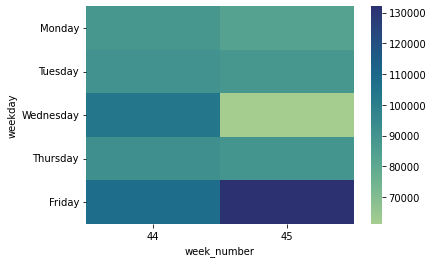

In [19]:
from pandas import DataFrame
import seaborn as sns
import time
%matplotlib inline

df_processed_timeframed['seconds'] = [d.total_seconds() for d in df_processed_timeframed['duration']]

df_processed_groupedbyID = pd.DataFrame({'seconds' : df_processed_timeframed.groupby(['week_number', 'weekday'])['seconds'].sum()}).reset_index()

df_heatmap = df_processed_groupedbyID.pivot(index='weekday', columns='week_number', values='seconds')
df_heatmap.index = pd.CategoricalIndex(df_heatmap.index, categories= ['Saturday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Sunday'])
df_heatmap.sort_index(level=0, inplace=True)

mask = df_heatmap.isnull()
sns.heatmap(df_heatmap, annot=False, fmt="g", cmap='crest', mask=mask)
plt.show()

# Pie chart of time spent in different scenes

In [52]:
df_sessions = pd.DataFrame({'duration' : df_processed_timeframed.groupby( [ "sceneId"] )['duration'].sum()}).reset_index()
df_sessions['duration_sec'] = [d.total_seconds() for d in df_sessions['duration']]
df_sessions

,sceneId,duration,duration_sec
0,3,0 days 23:36:30,84990.0
1,6,1 days 06:50:26,111026.0
2,8,1 days 03:28:39,98919.0
3,11,2 days 07:41:14,200474.0


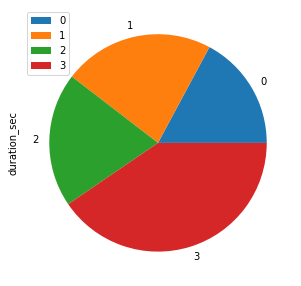

In [53]:
plot = df_sessions.plot.pie(y='duration_sec', figsize=(5, 5))

### Bar Chart showing how long users spent in sessions

<BarContainer object of 50 artists>

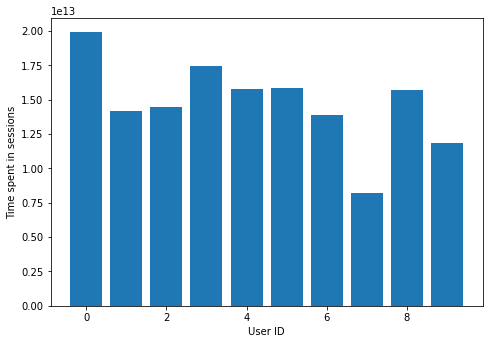

In [54]:
# df_processed.plot(x="userId", y=["times"])

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_ylabel('Time spent in sessions')
ax.set_xlabel('User ID')
ax.bar(df_processed_timeframed['userId'], df_processed_timeframed['duration'])

# Heatmap showing time spent in session for each user during a week

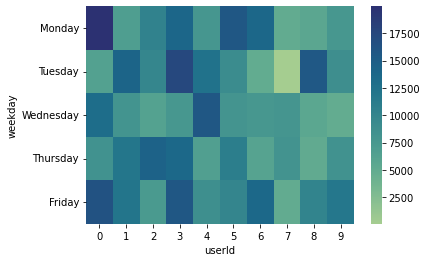

In [56]:
from pandas import DataFrame
import seaborn as sns
import time
%matplotlib inline

df_processed_timeframed['seconds'] = [d.total_seconds() for d in df_processed_timeframed['duration']]

df_processed_groupedbyID = pd.DataFrame({'seconds' : df_processed_timeframed.groupby(['userId', 'weekday'])['seconds'].sum()}).reset_index()

df_heatmap = df_processed_groupedbyID.pivot(index='weekday', columns='userId', values='seconds')
df_heatmap.index = pd.CategoricalIndex(df_heatmap.index, categories= ['Saturday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Sunday'])
df_heatmap.sort_index(level=0, inplace=True)

mask = df_heatmap.isnull()
sns.heatmap(df_heatmap, annot=False, fmt="g", cmap='crest', mask=mask)
plt.show()

In [74]:
df_processed_groupedbyID.head()


,userId,weekday,seconds
0,0,Friday,16341.0
1,0,Monday,19946.0
2,0,Thursday,8312.0
3,0,Tuesday,6317.0
4,0,Wednesday,13104.0


## Show ratings of users


In [62]:
df_rating = df_timeframed.drop(df_timeframed[df_timeframed['type'] != "CORE_SCENE_RATE"].index)
df_rating.head()

,type,userId,sessionId,sceneId,timestamp,data
id,,,,,,
1114,CORE_SCENE_RATE,0,63,6,2021-11-05 15:49:06,"{'rating': 2, 'rating_cat': 'Chat'}"
1117,CORE_SCENE_RATE,1,63,6,2021-11-05 15:11:35,"{'rating': 2, 'rating_cat': 'Collab Tools'}"
1122,CORE_SCENE_RATE,3,63,6,2021-11-05 14:52:55,"{'rating': 0, 'rating_cat': 'Network'}"
1125,CORE_SCENE_RATE,4,63,6,2021-11-05 13:51:13,"{'rating': 4, 'rating_cat': 'Cat6'}"
1134,CORE_SCENE_RATE,8,63,6,2021-11-05 12:47:30,"{'rating': 3, 'rating_cat': 'Cat6'}"


In [63]:
import ast
df_rating['data_str'] = [ast.literal_eval(str(d)) for d in df_rating['data']]
df_rating['rating'] = [d['rating'] for d in df_rating['data_str']]
df_rating['rating_cat'] = [d['rating_cat'] for d in df_rating['data_str']]
df_rating = df_rating.drop('data', axis=1)
df_rating = df_rating.drop('data_str', axis=1)
df_rating.head()

,type,userId,sessionId,sceneId,timestamp,rating,rating_cat
id,,,,,,,
1114,CORE_SCENE_RATE,0,63,6,2021-11-05 15:49:06,2,Chat
1117,CORE_SCENE_RATE,1,63,6,2021-11-05 15:11:35,2,Collab Tools
1122,CORE_SCENE_RATE,3,63,6,2021-11-05 14:52:55,0,Network
1125,CORE_SCENE_RATE,4,63,6,2021-11-05 13:51:13,4,Cat6
1134,CORE_SCENE_RATE,8,63,6,2021-11-05 12:47:30,3,Cat6


In [64]:
df_rating_grouped = pd.DataFrame({'temp' : df_rating.groupby(["rating"])['type']}).reset_index()
df_rating_grouped['count'] = [len(d[1]) for d in df_rating_grouped['temp']]
df_rating_grouped = df_rating_grouped.drop('temp', axis=1)
df_rating_grouped.columns = ['rating', 'count']
df_rating_grouped


,rating,count
0,0,5
1,1,5
2,2,5
3,3,6
4,4,5
5,5,1


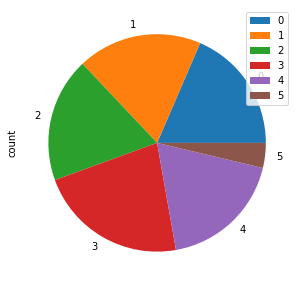

In [65]:
plot = df_rating_grouped.plot.pie(y='count', figsize=(5, 5))

# Histograms

In [66]:
def get_times_active(row):
    end = row['time'].hour
    start = row['time'].hour - row['duration'].seconds//3600
    return_set = set()
    for i in range(end - start + 1):
        return_set.add(str(start + i))
    return return_set

df_processed_timeframed['hours_active'] = df_processed_timeframed.apply(get_times_active, axis=1) 
df_processed_timeframed

,userId,sessionId,date,duration,time,weekday,sceneId,seconds,hours_active
id,,,,,,,,,
1113,0,63,2021-11-05,0 days 04:32:21,15:47:27,Friday,6,16341.0,"{15, 11, 13, 12, 14}"
1116,1,63,2021-11-05,0 days 03:22:45,15:09:54,Friday,6,12165.0,"{13, 12, 15, 14}"
1119,2,63,2021-11-05,0 days 02:02:15,12:30:26,Friday,6,7335.0,"{11, 12, 10}"
1121,3,63,2021-11-05,0 days 04:23:27,14:52:42,Friday,6,15807.0,"{11, 10, 13, 12, 14}"
1124,4,63,2021-11-05,0 days 02:25:42,13:49:30,Friday,6,8742.0,"{11, 13, 12}"
1127,5,63,2021-11-05,0 days 02:45:46,16:32:24,Friday,6,9946.0,"{16, 15, 14}"
1129,6,63,2021-11-05,0 days 03:48:10,16:26:19,Friday,6,13690.0,"{16, 13, 15, 14}"
1131,7,63,2021-11-05,0 days 01:23:10,12:57:04,Friday,6,4990.0,"{11, 12}"
1133,8,63,2021-11-05,0 days 02:50:07,12:46:35,Friday,6,10207.0,"{11, 12, 10}"


In [67]:
df_pre_fri_hist = df_processed_timeframed.loc[df_processed['weekday'] == 'Monday']
df_pre_fri_hist

,userId,sessionId,date,duration,time,weekday,sceneId,seconds,hours_active
id,,,,,,,,,
1138,0,66,2021-11-08,0 days 05:32:26,15:45:36,Monday,11,19946.0,"{15, 11, 10, 13, 12, 14}"
1141,1,66,2021-11-08,0 days 01:52:39,13:02:17,Monday,11,6759.0,"{13, 12}"
1144,2,66,2021-11-08,0 days 02:53:04,13:50:34,Monday,11,10384.0,"{11, 13, 12}"
1147,3,66,2021-11-08,0 days 03:52:36,14:28:54,Monday,11,13956.0,"{11, 13, 12, 14}"
1149,4,66,2021-11-08,0 days 02:09:44,12:57:52,Monday,11,7784.0,"{11, 12, 10}"
1152,5,66,2021-11-08,0 days 04:23:50,14:58:03,Monday,11,15830.0,"{11, 10, 13, 12, 14}"
1155,6,66,2021-11-08,0 days 03:51:09,13:59:54,Monday,11,13869.0,"{11, 13, 12, 10}"
1157,7,66,2021-11-08,0 days 01:23:38,12:41:25,Monday,11,5018.0,"{11, 12}"
1160,8,66,2021-11-08,0 days 01:33:19,12:43:48,Monday,11,5599.0,"{11, 12}"


In [68]:
data_for_hist = {}
            
count = 0
for times in df_pre_fri_hist['hours_active']:
    for time in times:
        data_for_hist[count] = float(time)
        count += 1
    
df_fri_hist = pd.DataFrame(data_for_hist, index = [0])
df_fri_hist = df_fri_hist.reindex(sorted(df_fri_hist.columns), axis=1)
df_fri_hist

,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
0,15.0,11.0,10.0,13.0,12.0,14.0,13.0,12.0,11.0,13.0,...,13.0,12.0,10.0,11.0,12.0,11.0,12.0,11.0,12.0,10.0


In [69]:
df_fri_hist.max(axis=1)[0]

15.0

## Histogram showing concurrent users throughout an average day

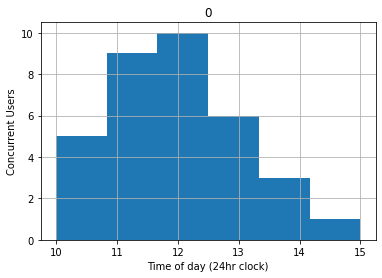

In [70]:
axarr = df_fri_hist.transpose().hist(bins=6)

for ax in axarr.flatten():
    ax.set_xlabel("Time of day (24hr clock)")
    ax.set_ylabel("Concurrent Users")

## Histogram showing length of sessions

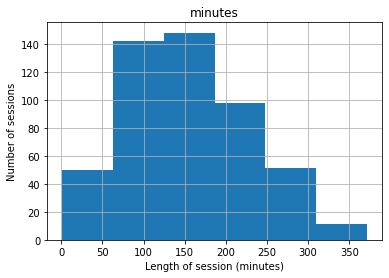

In [71]:
df_sesh_len_hist = df_processed[['duration']].copy()
df_sesh_len_hist['minutes'] = [d.total_seconds()/60 for d in df_processed['duration']]
df_min_hist = df_sesh_len_hist[['minutes']].copy()
axarr = df_min_hist.hist(bins=6)

for ax in axarr.flatten():
    ax.set_xlabel("Length of session (minutes)")
    ax.set_ylabel("Number of sessions")

## Radar graph showing average ratings for each category

In [72]:
df_rating_cat_grouped = pd.DataFrame({'mean' : df_rating.groupby(["rating_cat"])['rating'].mean()}).reset_index()
df_rating_cat_grouped

,rating_cat,mean
0,Cat4,2.428571
1,Cat5,3.400000
2,Cat6,4.000000
3,Chat,2.333333
4,Collab Tools,0.833333
5,Network,0.000000


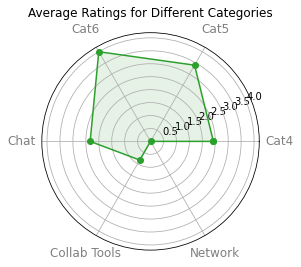

In [73]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="polar")

# theta has 5 different angles, and the first one repeated
theta = np.arange(len(df_rating_cat_grouped) + 1) / float(len(df_rating_cat_grouped)) * 2 * np.pi
# values has the 5 values from 'mean', with the first element repeated
values = df_rating_cat_grouped['mean'].values
values = np.append(values, values[0])

# draw the polygon and the mark the points for each angle/value combination
l1, = ax.plot(theta, values, color="C2", marker="o", label="Mean rating")
plt.xticks(theta[:-1], df_rating_cat_grouped['rating_cat'], color='grey', size=12)
ax.tick_params(pad=10) # to increase the distance of the labels to the plot
# fill the area of the polygon with green and some transparency
ax.fill(theta, values, 'green', alpha=0.1)

# plt.legend() # shows the legend, using the label of the line plot (useful when there is more than 1 polygon)
plt.title("Average Ratings for Different Categories")
plt.show()

In [10]:
dt.datetime.now().timestamp()

1636683426.39389

In [11]:
# histogram showing concurrent users in a scene (throughout day)
# smiley face rating for users to rate the session (store in data)
# histogram showing length of session for users in a week (timeframe)